In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from tqdm.auto import tqdm



In [68]:
df = pd.read_csv("../02_regression/data/data.csv")
print(df.shape)
df.info()  

(11914, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64

In [69]:
# preprocessing
cols_to_leave = ["Make","Model","Year","Engine HP","Engine Cylinders","Transmission Type","Vehicle Style","highway MPG","city mpg","MSRP"]
df = df[cols_to_leave]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={"MSRP".lower(): "price"})

df["above_average"] = (df.price > df.price.mean()).astype(int)
df = df.drop("price", axis=1)
print(df.above_average.value_counts())

0    8645
1    3269
Name: above_average, dtype: int64


In [70]:
# train test split

df_full_train, dfts = train_test_split(df, test_size=0.2, random_state=42)
dftr, dfvl = train_test_split(df_full_train, test_size=0.25, random_state=42)
print(dftr.shape, dfvl.shape, dfts.shape)

(7148, 10) (2383, 10) (2383, 10)


## Q1

In [71]:
numericals = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

stats = {}
for f in numericals:
    stats[f] = auc(sorted(dftr[f].values), sorted(dftr.above_average.values))

print(stats)

{'engine_hp': 709.0, 'engine_cylinders': 10.0, 'highway_mpg': 324.0, 'city_mpg': 115.0}


## Q2

In [74]:
dv = DictVectorizer(sparse=False)

train_dicts = dftr.drop("above_average", axis=1).to_dict(orient="records")
xtr = dv.fit_transform(train_dicts)

val_dicts = dfvl.drop("above_average", axis=1).to_dict(orient="records")
xvl = dv.transform(val_dicts)

ytr = dftr.above_average.values
yvl = dfvl.above_average.values

print(xtr.shape, ytr.shape, xvl.shape, yvl.shape)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(xtr, ytr)

preds = model.predict(xvl)
roc_auc_score(preds, yvl)

(7148, 943) (7148,) (2383, 943) (2383,)


0.9298650902005021

## Q3

/tmp/ipykernel_33923/3873153095.py:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


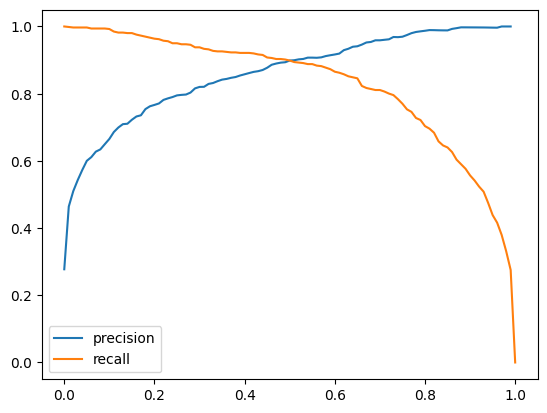

In [62]:
def tpr_fpr_df(yvl, ypred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (yvl == 1)
        actual_negative = (yvl == 0)
    
        predict_positive = (ypred >= t)
        predict_negative = (ypred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall))

    columns = ["threshold", "tp", "fp", "fn", "tn", "precision", "recall"]
    df = pd.DataFrame(scores, columns=columns)

    df["tpr"] = df.tp / (df.tp + df.fn)
    df["fpr"] = df.fp / (df.fp + df.tn)

    return df

probs = model.predict_proba(xvl)[:,1]
df = tpr_fpr_df(yvl, probs)

plt.plot(df.threshold, df.precision, label="precision")
plt.plot(df.threshold, df.recall, label="recall")
plt.legend();

In [63]:
df[df.precision == df.recall]

,threshold,tp,fp,fn,tn,precision,recall,tpr,fpr
50,0.5,594,67,67,1655,0.898638,0.898638,0.898638,0.038908


## Q4

In [64]:
def tpr_fpr_df(yvl, ypred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (yvl == 1)
        actual_negative = (yvl == 0)
    
        predict_positive = (ypred >= t)
        predict_negative = (ypred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp+fn)

        f1 = 2 * precision * recall / (precision + recall)

        scores.append((t, tp, fp, fn, tn, precision, recall, f1))

    columns = ["threshold", "tp", "fp", "fn", "tn", "precision", "recall", "f1"]
    df = pd.DataFrame(scores, columns=columns)

    df["tpr"] = df.tp / (df.tp + df.fn)
    df["fpr"] = df.fp / (df.fp + df.tn)

    return df

df = tpr_fpr_df(yvl, probs)
df[df.f1 == df.f1.max()]

/tmp/ipykernel_33923/2706688809.py:16: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,threshold,tp,fp,fn,tn,precision,recall,f1,tpr,fpr
50,0.5,594,67,67,1655,0.898638,0.898638,0.898638,0.898638,0.038908


## Q5

In [80]:

def train(df, ytr, C=1.0):
    dicts = df.drop("above_average", axis=1).to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    xtr = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(xtr, ytr)

    return dv, model

def predict(df, dv, model):
    dicts = df.drop("above_average", axis=1).to_dict(orient='records')
    x = dv.transform(dicts)
    ypred = model.predict_proba(x)[:, 1]

    return ypred

kfold = KFold(n_splits=5,  shuffle=True, random_state=1)

scores = []
C = 1.0
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    
    dftr = df_full_train.iloc[train_idx]
    dfvl = df_full_train.iloc[val_idx]

    ytr = dftr.above_average.values
    yvl = dfvl.above_average.values

    dv, model = train(dftr, ytr, C)
    ypred = predict(dfvl, dv, model)

    auc = roc_auc_score(yvl, ypred)
    scores.append(auc)

print("%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

1.0 0.979 +- 0.002


/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
print("%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

1.0 0.979 +- 0.002


## Q6

In [84]:
stats = {}
for C in [0.01, 0.1, 0.5, 10]:

    scores = []
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        
        dftr = df_full_train.iloc[train_idx]
        dfvl = df_full_train.iloc[val_idx]

        ytr = dftr.above_average.values
        yvl = dfvl.above_average.values

        dv, model = train(dftr, ytr, C)
        ypred = predict(dfvl, dv, model)

        auc = roc_auc_score(yvl, ypred)
        scores.append(auc)

    stats[C] = (np.mean(scores), np.std(scores))


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

0it [00:00, ?it/s]

/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hilbert/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [85]:
stats

{0.01: (0.9511393663731393, 0.005435443700720982),
 0.1: (0.971471966508495, 0.0031138594511063624),
 0.5: (0.9770665569823015, 0.002349080672805816),
 10: (0.9790670560087262, 0.0027202573360932025)}